In [1]:
#Primary stage Parameters - not affected by Beam Initial Energy
p = 1.77
alpha = 0.0022
beta = 0.012
gamma = 0.6
epsilon = 0.0 #ranges 0.0 to 0.2
e_2 = 997 # density of the medium 
sd = 0.01

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import scipy as sp
import scipy.special.cython_special 
import math as math
import pandas as pd
import itertools as it

from scipy.misc import derivative as dv #unsurprisingly is the derivative function 
from scipy import integrate
from scipy.optimize import minimize
from scipy.optimize import lsq_linear

import sympy as sym

import numpy.ma as ma #this was for the joint curves but not implemented anymore 

import statistics as stat #used for shorthand standard deviation and mean calculation (yes im that lazy to calculate mean)
plt.style.use('default')

def CalculateXAxis(eZero): # Send in a single eZero Value, returns the x-axis to scale

    rZeroMax = alpha*(eZero**p) 
    z = np.arange(0,rZeroMax*1.1,0.1) #multiply by 1.1 to allow the plot to have greater range (visually nicer).
    
    return(z)

def CalculateXAxisList(eZeroList): # Send in a multiple eZero Values in List/tuple... returns the x-axis to scale 

    eZeroMax = int(max(eZeroList)) # Seleceting the greatest eZero to allow for all curves to be shown in plot 
    rZeroMax = alpha*((eZeroMax**p))
    z = np.arange(0,rZeroMax*1.1,0.1) #multiply by 1.1 to allow the plot to have greater range (visually nicer).
    
    return(z)

def CalculateSecondary(eZero,z): 
    # Send in eZero and the specific x axis, returns all calculated values and dict for df visualisation later
        
    #Secondary Stage Parameters
    rZero = alpha*(pow(eZero,p))
    sigE0 = 0.01*eZero
    sigMono = beta*(rZero**0.935)
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -z)/sigma
    phiZero = 1 + beta*(rZero)
    
    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))
    
    #Appending few data to dictionary for DataFrame use 
    secondaryData = {"eZero":eZero, "rZero": rZero,"sigma":sigma,
                     "phiZero":phiZero}
    
    return(secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)


def CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2): 
    # Send in Values calculated in CalculateSecondary(...), returns the curve function (set of discrete points).
    
    curve =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)

    return(curve)
def CalculateSingularPBC(eZero,df): #Send in MeV, returns curve and Dataframe with information about the curve.
    
    #Predefined Variables
    z = CalculateXAxis(eZero)
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

def CalculateMultiplePBC(eZero,z,df): #Send in MeV, returns curve values.
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

def CalculateSingularPBCNoDF(eZero): #Send in MeV, returns curve and Dataframe with information about the curve.
    
    #Predefined Variables
    z = CalculateXAxis(eZero)
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    
    return(curve)

def CalculateMultiplePBCNoDF(eZero,z): #Send in MeV, returns curve values.
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    return(curve)

def PlotCurve(eZero): # Send in ONE eZero, Calculates individual PBC and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curve, CurveData = CalculateSingularPBC(eZero,CurveData)
    z = CalculateXAxis(eZero)
    plt.plot(z,curve, label = (str(eZero)+ "MeV"))
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Individual Bragg Curve Plot")
    
    plt.legend(loc='best')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
def PlotCumulativeCurve(eZero): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBC(i,z, CurveData)
        curveList.append(curve)
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative Proton Beam Curve Plot")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
    
def PlotCumulativeCurveAndInd(eZero): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBC(i,z,CurveData)
        curveList.append(curve)
        plt.plot(z,curve, label = (str(i)+ "MeV"))
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative and Individual Proton Beam Curve Plot")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
def InteractivePlot():

    text = ""
    while text != 4:
        eZeroList = []
    
        text = int(input("Menu. Choose Menu item: \n 1: Plot Individual PBC(s)"
             +"\n 2: Plot Only Cumulative Curve \n 3: Plot Cumulative Curve and Individual PBC(s)"
             +"\n 4: Quit \n"))
    
        if text ==1 or text ==2 or text ==3:
            amountOfCurves = int(input("Enter amount of Curves: "))
            for i in range(amountOfCurves):
                eZero = int(input("Enter eZero number "+ str(i+1)+ ": "))
                if text ==1:
                    PlotCurve(eZero)
                eZeroList.append(eZero)
            plt.show()
            
            if text ==2:
                PlotCumulativeCurve(eZeroList)
                plt.show()
            elif text ==3:
                PlotCumulativeCurveAndInd(eZeroList)
                plt.show()
def PlotSimpleBox(): 
    #takes no aguments, plots dashed lines of tumour range and doseage required
    plt.hlines(y=0.1,xmin = 12,xmax = 15, color='r', linestyles='dashed')
    plt.vlines(x=12,ymin = 0,ymax = 0.1, color='r', linestyles='dashed')
    plt.vlines(x=15,ymin = 0,ymax = 0.1, color='r', linestyles='dashed', label = "Target Range")

def PlotCustomBox(upper,lower,dose):
    # takes three aguments. Upper and lower dispalcement values and target doseage value.
    # plots dashed lines of tumour range and doseage required
    plt.hlines(y=dose,xmin = lower,xmax = upper, color='r', linestyles='dashed', label = "Target Dose")
    #plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    #plt.hlines(y=0,xmin = upper,xmax = 20, color='r', linestyles='dashed')
    plt.vlines(x=lower,ymin = 0,ymax = dose, color='r', linestyles='dashed')
    plt.vlines(x=upper,ymin = 0,ymax = dose, color='r', linestyles='dashed') #, label = "Target Range"'
    

def CalculateMaxCurves(dose, upper, energyData):
    df = energyData[(energyData["rMax"] <= upper)]
    eZero = max(df.eZero)
    curve,df = CalculateSingularPBC(eZero,df)
    eInitial = curve[0]
    
    maxCurves = int((dose // eInitial)+1)
    
    return(maxCurves)
def RestrictDfRanges(df, lower,upper):
    # takes energyData DataFrame, lower bound and upper bound of the target range as arguments.
    # Returns a new trimmed DataFrame restricted to the rMax values greaters than or equal to lower bound
    # and less than or equal to upper bound.

    df2 = energyData[(energyData["rMax"] >= lower)]
    df2 = df2[(df2["rMax"] <= upper)]

    return(df2)
def CalculateInfo(dose,lower, upper, SOBP):
    # Takes targetDose, lower bound and upper bound of target range and the SOBP curve as arguments.
    # Returns Standard Deviation, Average Distance of curve to target dose, Percentage of the SOBP Above Dose Line.
    
    lower = int(lower)
    upper = int(upper)
    avgDistList = []
    z2 = np.arange(lower,upper,0.1)
    regionOfCurve = SOBP[lower*10:upper*10] #times 10 as z has 0.1 increments 
    
    stdDev = np.std(regionOfCurve)
    
    #Calculating the average distance away from the curve in the y axis and percentageAboveDose 
    counter = 0
    
    for i in regionOfCurve:
        avgDist = dose-i
        if avgDist<=0:
            counter = counter +1
            avgDist = abs(avgDist)
        avgDistList.append(avgDist)
    avgDist = sum(avgDistList)/len(avgDistList)
    
    percentageAboveDose = counter/len(SOBP[lower*10:upper*10])
    
    return(stdDev, avgDist, percentageAboveDose)
    
def Optimiser(): 
    # Takes no arguments, returns DataFrame of SOBP curves in rank order.
    
    option = int(input("Choose Simple Box? \n 1:yes \n 0:no \n"))

    if option == 0:
        upper = round(float(input( "upper Bound Value (float): ")),2)
        lower = round(float(input( "lower Bound Value (float): ")),2)
        dose = round(float(input( "Dose Value (float): ")),2)
        PlotCustomBox(upper,lower,dose)
    
    elif option == 1:
        PlotSimpleBox()
        upper = 15
        lower = 12
        dose = 0.1 
        
    mxNo = CalculateMaxCurves(dose, upper, energyData) #max # of curves i should use to get the SOBP else dosage too high
    print("Your given doseage has upper bound number of curves needed as " + str(mxNo))
    r = int(input("Number of curves to use (maximum is 5)? :")) # change to the optimised version later
    
    #trim the range of energyValues()
    df = RestrictDfRanges(energyData,lower,upper)
    
    #defining variables:
    cdf = pd.DataFrame() #dataFrame to contain the energy Values and stats about the SOBP 
    
    eZeroOne = None
    eZeroTwo = None
    eZeroThree = None
    eZeroFour = None
    eZeroFive = None
    curveList = []
    eZeroList = [] # list used to hold all eZero values
    
    #Combinations
    n = len(df.eZero) # the amount of eZero values to iterate through 
    print(" r = "+str(r)+ "\n n = "+ str(n))
    
   
    for i in range(n-1):
        eZeroList.append(df.eZero.iloc[i])
    # eZeroList now hold all eZero values
    
    combList = list(it.combinations_with_replacement(eZeroList,r))
    #comb list now holds all the combinations of values in eZeroList.
    
    print("Total amount of combinations = " + str(len(combList))) 

    for combo in combList:
        curveList =[] 
        z = CalculateXAxisList(combo)
            
        for eZero in combo:
            curve,df = CalculateMultiplePBC(eZero,z, df) # Calculate individual PBC
            curveList.append(curve) 

        sobp = sum(curveList) # Calculate SOBP
            
        stdDev, avgDist, percentageAboveDose= CalculateInfo(dose,lower, upper,sobp) # Calculate the info for the df later

        #append data to cdf
        if r == 2:
            eZeroOne = combo[0];eZeroTwo = combo[1]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 3:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 4: 
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r ==5:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];eZeroFive = combo[4]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                     "eZeroFive": eZeroFive,"standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,
                     "percentageAboveDoseLine":percentageAboveDose}

        beamData = pd.Series(data = datum,index = datum.keys())
        cdf = pd.concat([cdf, beamData.to_frame().T], ignore_index=True)


    #sort the df by percentageAboveDoseLine values
    df2 = cdf.sort_values(by = ['percentageAboveDoseLine','averageDisplacementFromDose'], ascending = [False,True])
    
    for j in range(3): #for the top 3 curves  
        eVals = []          
        for i in range(r): # take the n curves that make the sobp
            eVals.append(df2.iloc[j][i]) #add the eZeros to a list 
        print("BEST CURVE NUMBER "+str(j+1))
        PlotCumulativeCurveAndInd(eVals) #Plot the List 
        PlotCustomBox(upper,lower,dose)
        plt.show()
    return(df2)
def CalculateSecondaryNorm(eZero,z, theta):
    
    phi = np.random.normal(0,theta,1)
    #Secondary Stage Parameters
    rZero = alpha*(eZero**p)
    sigE0 = 0.01*eZero
    sigMono = beta*(rZero**0.935)
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -(z+phi))/sigma
    phiZero = 1 + beta*(rZero)
    
    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))
    
    #Appending few data to dictionary for DataFrame use 
    secondaryData = {"eZero":eZero, "rZero": rZero,"theta":theta,
                     "phi":round(float(phi),2)}
    
    
    
    return(secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z)
def CalculateSingularPBCNorm(eZero,df,theta): #Send in MeV, returns curve and Dataframe with information about the curve.
    
    #Predefined Variables
    z = CalculateXAxis(eZero)
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z = CalculateSecondaryNorm(eZero,z,theta)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

def CalculateMultiplePBCNorm(eZero,z,df,theta): 
    # Send in eZero, rnage of dispalceent Valeus, DataFrame to contain data, and Standard eviation.
    # Returns curve values.
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z = CalculateSecondaryNorm(eZero,z,theta)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)
def PlotCurveNorm(eZero,theta): # Send in ONE eZero, Calculates individual PBC and Plots, returns nothing. 
    
    CurveData = pd.DataFrame()
    curve, CurveData = CalculateSingularPBCNorm(eZero,CurveData,theta)
    z = CalculateXAxis(eZero)
    plt.plot(z,curve, label = (str(eZero)+ "MeV"))
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Individual Proton Beam Curve Plot WITH uncertainty")
    
    plt.legend(loc='best')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
def PlotCumulativeCurveNorm(eZero,theta): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBCNorm(i,z, CurveData,theta)
        curveList.append(curve)
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative Proton Beam Curve Plot WITH uncertainty")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
    
def PlotCumulativeCurveAndIndNorm(eZero,theta): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBCNorm(i,z,CurveData,theta)
        curveList.append(curve)
        plt.plot(z,curve, label = (str(i)+ "MeV"))
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative and Individual Proton Beam Curve Plot WITH uncertainty")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
def InteractivePlotNorm():

    text = ""
    while text != 4:
        eZeroList = []
    
        text = int(input("Menu. Choose Menu item: \n 1: Plot Individual PBC(s) with Uncertainty"
             +"\n 2: Plot Only Cumulative Curve with Uncertainty \n 3: Plot Cumulative Curve and Individual PBC(s) with Uncertainty"
             +"\n 4: Quit \n"))
    
        if text ==1 or text ==2 or text ==3:
            amountOfCurves = int(input("Enter amount of Curves: "))
            theta = float(input("Enter value for Theta: "))
            for i in range(amountOfCurves):
                eZero = int(input("Enter eZero number "+ str(i+1)+ ": "))
                if text ==1:
                    PlotCurveNorm(eZero,theta)
                eZeroList.append(eZero)
            plt.show()
            
            if text ==2:
                PlotCumulativeCurveNorm(eZeroList,theta)
                plt.show()
            elif text ==3:
                PlotCumulativeCurveAndIndNorm(eZeroList,theta)
                plt.show()
def PlotVisualisations(eZero,n, theta):
#Predefined Variables
    curveList = []
#Start:

    PlotCurveNorm(eZero,0)

#retrieve all the energies first to work out max range for final plot
    z = CalculateXAxis(eZero)
    for i in range(n): 

    
    #Calculating Data
        secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z = CalculateSecondaryNorm(eZero,z,theta)
        curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        curveList.append(curve)
    
    #plotting
        plt.plot(z,curve, color = "pink",alpha = 0.02)
#details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Proton Beam Curve with "+str(n)+ " samples of uncertain PBCs")
    plt.grid(True)
    plt.xlim([0,(z[len(z)-1] +theta*3)]) #restricting the area to upper bound it by 3 times the theta 
def PlotSingularPBCNormEB(eZero,nStdDev,theta):
    
    #Calculating Data
    z = CalculateXAxis(eZero)
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z);
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    #plotting
        #random colors
    r = round(float(np.random.uniform(0,1,1)),1)
    g = round(float(np.random.uniform(0,1,1)),1)
    b = round(float(np.random.uniform(0,1,1)),1)
    plt.plot(z,curve, label =  (str(eZero)+ "MeV"),color = (r,g,b))
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Proton Beam Curve with Error bars of "+str(nStandardDeviations)+" Standard Deviations ")
    plt.legend(loc = "upper left")
    #error bar
    plt.errorbar(z,curve,xerr = nStandardDeviations*theta, elinewidth = 0.5,color = (r,g,b))
    plt.xlim(0,z[len(z)-1]+(nStandardDeviations*theta))
def PlotCumulativeCurveNormEB(eZero,nStdDev,theta):
    
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    amountOfCurves = len(eZero)
    #Calculating Data
    z = CalculateXAxisList(eZero)
     
    for i in eZero:
        curve,CurveData = CalculateMultiplePBC(i,z, CurveData)
        curveList.append(curve)
        
    cumulativeCurve = sum(curveList)
    
    #plotting 
    plt.plot(z,cumulativeCurve, color = "k", label = "Cumulative Curve")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("SOBP with Error Bars of "+str(nStandardDeviations)+" Standard Deviations ")
    plt.legend(loc = "upper left")
    
    #error bar
    plt.errorbar(z,cumulativeCurve,xerr = nStandardDeviations*theta*amountOfCurves, color = "k", elinewidth = 0.5)
    plt.xlim(0,z[len(z)-1]+(nStandardDeviations*theta))
    plt.grid(True)
    plt.show()

def PlotCumulativeCurveAndIndNormEB(eZero, nStdDev, theta):
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    amountOfCurves = len(eZero)
    
    for i in eZero:
        
        #random colors
        r = round(float(np.random.uniform(0,1,1)),1)
        g = round(float(np.random.uniform(0,1,1)),1)
        b = round(float(np.random.uniform(0,1,1)),1)
        
        curve,CurveData = CalculateMultiplePBC(i,z,CurveData)
        curveList.append(curve)
        #plot
        plt.plot(z,curve, label = (str(i)+ "MeV"),color = (r,g,b))
        #error bar
        plt.errorbar(z,curve,xerr = nStandardDeviations*theta, elinewidth = 0.5, color = (r,g,b))
        
    cumulativeCurve = sum(curveList)
    
    #plotting
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("SOBP and Individual Proton Beam Curve Plot with "+str(nStdDev)+" Error Bars")
    
    #error bar
    plt.errorbar(z,cumulativeCurve,xerr = nStandardDeviations*theta*amountOfCurves, color = "k", elinewidth = 0.5)
    
    plt.legend(loc='upper left')
    plt.grid(True)
def PlotCustomBoxError(upper,lower,dose):
    plt.vlines(x=lower,ymin = 0,ymax = dose, color='b', linestyles='dashed')
    plt.vlines(x=upper,ymin = 0,ymax = dose, color='b', linestyles='dashed')
def OptimiserWithUncertainty(): 
    # Takes no arguments, returns DataFrame of SOBP curves in rank order.
    
    theta = float(input("Theta value: "))
    nStnDev = int(input("Amount of standard deviations (1,2 OR 3): "))
    option = int(input("Choose Simple Box? \n 1:yes \n 0:no \n"))

    if option == 0:
        
        upper = round(float(input( "upper Bound Value (float): ")),2) 
        lower = round(float(input( "lower Bound Value (float): ")),2)
        dose = round(float(input( "Dose Value (float): ")),2)
        mxNo = CalculateMaxCurves(dose, upper, energyData) #max # of curves i should use to get the SOBP else dosage too high
        print("Your given doseage has upper bound number of curves needed as " + str(mxNo))
        r = int(input("Number of curves to use (maximum is 5)? :")) # change to the optimised version later

        upperErr = upper - r*nStnDev*theta
        lowerErr = lower + r*nStnDev*theta 
        
        
       
        
    
    elif option == 1:
        
        upper = 15
        lower = 12
        dose = 0.1 
        
        mxNo = CalculateMaxCurves(dose, upper, energyData) #max # of curves i should use to get the SOBP else dosage too high
        print("Your given doseage has upper bound number of curves needed as " + str(mxNo))
        r = int(input("Number of curves to use (maximum is 5)? :")) # change to the optimised version later
        
        upperErr = upper - r*nStnDev*theta
        lowerErr = lower + r*nStnDev*theta 
        
    
    elif (upper - lower)/(nStnDev*2) <= (theta):
        print("No solutions, Error range too large")
        return()
    
    #trim the range of energyValues()
    df = RestrictDfRanges(energyData,lowerErr,upperErr)
    
    #defining variables:
    cdf = pd.DataFrame() #dataFrame to contain the energy Values and stats about the SOBP 
    
    eZeroOne = None
    eZeroTwo = None
    eZeroThree = None
    eZeroFour = None
    eZeroFive = None
    curveList = [] # list used to hold all PBC in calculation for SOBP curve
    eZeroList = [] # list used to hold all eZero values
    uncerList = [] # list used to hold the uncertainty value for every curve
     
    #Combinations
    n = len(df.eZero) # the amount of eZero values to iterate through 
    print(" r = "+str(r)+ "\n n = "+ str(n))
    
   
    for i in range(n-1):
        eZeroList.append(df.eZero.iloc[i])
    # eZeroList now hold all eZero values
    
    combList = list(it.combinations_with_replacement(eZeroList,r))
    #comb list now holds all the combinations of values in eZeroList.
    
    print("Total amount of combinations = " + str(len(combList))) 

    for combo in combList:
        curveList =[] 
        z = CalculateXAxisList(combo)
            
        for eZero in combo:
            curve,df = CalculateMultiplePBC(eZero,z, df) # Calculate individual PBC
            curveList.append(curve) 

        sobp = sum(curveList) # Calculate SOBP
            
        stdDev, avgDist, percentageAboveDose= CalculateInfo(dose,lower, upper,sobp) # Calculate the info for the df later

        #append data to cdf
        if r == 2:
            eZeroOne = combo[0];eZeroTwo = combo[1]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 3:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 4: 
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r ==5:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];eZeroFive = combo[4]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                     "eZeroFive": eZeroFive,"standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,
                     "percentageAboveDoseLine":percentageAboveDose}
            
        uncerList.append(r*nStnDev*theta)
        beamData = pd.Series(data = datum,index = datum.keys())
        cdf = pd.concat([cdf, beamData.to_frame().T], ignore_index=True)


    #sort the df by percentageAboveDoseLine values
    cdf["TotalUncertainty"] = uncerList
    cdf = cdf.sort_values(by = ['percentageAboveDoseLine','averageDisplacementFromDose'], ascending = [False,True])
    
    for j in range(3): #for the top 3 curves  
        eVals = []          
        for i in range(r): # take the n curves that make the sobp
            eVals.append(cdf.iloc[j][i]) #add the eZeros to a list 
        print("BEST CURVE NUMBER "+str(j+1))
        PlotCumulativeCurveAndIndNormEB(eVals,nStnDev,theta) #Plot the List 
        PlotCustomBoxError(upperErr,lowerErr,dose)
        PlotCustomBox(upper,lower,dose)
        plt.show()
    return(cdf) 
def Functionb(x,eZero):
    
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1.1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)

    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))

    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    y =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)
    return(y)
    
        
def Function3b(x,eZeroi,eZeroj): #used to fill M for the quadrature method.  
    a = Functionb(x,eZeroi)
    b = Functionb(x,eZeroj)
    c = a*b
    return(c)
    
def OptimiseLAb(lower, upper,dose, eVals): 
    # definine variables 
    n = len(eVals)
    if upper-lower  <= 4 and upper <5:
        z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.01)
    else:
        z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        
        for j in range(n): # for n evaleus 
            
            
            val,err = integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j]))
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        if i == 0:
            plt.plot(z,dList[i], label = "Bragg Curves", color = "blue", alpha = 0.4)
        else:
            plt.plot(z,dList[i], color = "blue", alpha = 0.4)



            
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose+0.3])
    plt.grid()
    plt.ylabel("Dose Per Fluence")
    plt.xlabel("Depth/cm")
    #plt.xlim([0,18])
    
    return(m,omega,f,d)



def OptimiseLAbNoPlot(lower, upper,dose, eVals): 
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    print("LENGTH OF Z ",len(z))
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 
            
            val,err = integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j]))
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        ###SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
   
    return(m,omega,f,d)
def OptimiseLARatioB(lower, upper,dose, eVals,theta,phi):
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 
             
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = theta*valTarget + phi*(valUpper+ valLower)
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        ###SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot. Phi = "+ str(phi))
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose+0.3])
    plt.xlim([0,18])
    
    return(m,omega,f,d)
def GetDb(x,omega,eVals):
    lst = []
    for i in range(len(eVals)): # for every value
        
        lst.append(omega[i]*Functionb(x,eVals[i])) # hold data in list 
    continousD = sum(lst) # y = f(x)
    return(continousD)

def GetDMinusOneNormedSquared(x,omega,eVals):
    d = GetDb(x,omega,eVals)
    y = pow(abs(d-dose),2)
    return(y)

In [2]:
def CalculatePeakDoseZValue(curve,z): 
    # takes curve, as calculated from CalculateCurve() function, and range of which to plot the curve as arguments
    # returns Peak Dose and displacement of point of Peak Dose
    
    rMax = 0
    peakDose = max(curve)
    
    for i in range(len(z)):
            if curve[i] == peakDose:
                rMax = i/100
                return(peakDose,rMax)
            
def FindBestLowerUpperEZeros(lower, upper):
    eZeroValues = np.arange(25,50,0.05)
    z = np.arange(0,3,0.01)
    energyData2 = pd.DataFrame()
    for eZero in eZeroValues: 
        curve = Functionb(z,eZero)
        plt.plot(z,curve)
        peakDose,rMax = CalculatePeakDoseZValue(curve,z)
        datum = {"eZero": eZero, "peakDose":peakDose,"rMax": rMax}
        beamData = pd.Series(data = datum,index = datum.keys())
        energyData2 = pd.concat([energyData2, beamData.to_frame().T], ignore_index=True)
    return(energyData2)

In [3]:
def GetQuadratureTSqrt(omega,eVals):
    #lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,1,2,args=(omega,eVals))
    y = np.sqrt(val)
    return(y)
    

In [4]:
def FunctionDeriv(x,eVal):

    h = 0.00001
    deriv = (Functionb((x+h),eVal) - Functionb(x,eVal))/(h)
    
    return(deriv)
    
def FunctionDeriv3(x,eVals):
    a = FunctionDeriv(x,eVals[0])
    b = FunctionDeriv(x,eVals[1])
    return(a*b)

   
def PenalizeDerivaive(lower,upper,dose,eVals,theta,phi,psi):
    
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*2,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = theta*valTarget + phi*(valUpper+ valLower)
            
            valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))
            valCorrected = valCorrected + psi*(valDeriv)
            
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,2])
    plt.xlim([0,18])
    
    return(m,omega,f,d)

def TristanFunciton(x,eZeroij,p2):
    deriv = FunctionDeriv(x,eZeroij[0])
    absolute = abs(deriv)
    lamda = pow(absolute,(p2-2))
    rho = FunctionDeriv3(x,eZeroij)
    delta = lamda* rho
    
    return(delta)
def PenalizeDerivaiveMore(lower,upper,dose,eVals,theta,phi,psi,p2):
    
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.2,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            #print(valTarget)
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = (theta*valTarget) + phi*(valUpper+ valLower)
            #print(valCorrected)
            valDeriv,err = integrate.quad(TristanFunciton,lower,upper,args = (eValsij,p2))
            valCorrected = valCorrected + psi*(valDeriv)
            #print(valCorrected)
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim([0,2])
    #plt.xlim([0,18])
    
    return(m,omega,f,d)



def GetQuadratureTSqrtPlusPsi(omega,eVals,psi):
    lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals)) 
    val2,err2 = integrate.quad(GetdPrimeNormSquared,12,15,args = (omega,eVals,psi))
    y = (val + val2)
    return(y)

def GetdPrimeNormSquared(x,omega,eVals,psi):
    dPrime = FunctionDeriv2(x,eVals,omega)
    y = psi*pow(abs(dPrime),2)
    
    return(y)
def FunctionDeriv2(x,eVals,omega):

    h = 0.001
    deriv = (GetDb((x+h),omega,eVals) - GetDb(x,omega,eVals))/(h)
    
    return(deriv)

def FunctionDPrimeNormSq(x,eZero,p2):
    dPrime = pow(abs(FunctionDeriv(x,eZero)),p2-2)
    dPrime = dPrime + TristanFunciton
    return(dPrime)


def TristanFunciton2(x,eZeroij,p2,eVals,omega):
    if p2 != 2:
        deriv = pow(abs(FunctionDeriv2(x,eVals,omega)),p2-2)
        rho = FunctionDeriv3(x,eZeroij)
        delta = deriv* rho
    else:
        deriv = 1
        rho = FunctionDeriv3(x,eZeroij)
        delta = deriv* rho
    
    return(delta)
def PenaliseDerivativeEvenMore(d,p2,lower,upper,dose,eVals,theta,phi,psi,oldOmega):
    
    # definine variables 
    n = len(eVals)
    
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    x = np.arange(0,30,0.1)
    #######################################################################################
    # QUADRATURE for N
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            
            #### THETA
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            #print(valTarget)
            #### PHI
            #valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            #valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
        
            #### PSI
            valDeriv,err = integrate.quad(TristanFunciton2,lower,upper,args = (eValsij,p2,eVals,oldOmega),limit = 10)
            #print(valDeriv)
            
            valCorrected = theta*(valTarget)  + psi*(valDeriv) #+ phi*(valUpper+ valLower)
            #print("vc",valCorrected)
            m[i,j] = valCorrected
    
   
    ######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(x,eVals[i]))) #collect the di's
        if i == 0:
            plt.plot(x,dList[i], alpha = 0.2, color = "b",label = "b")
        else:
            plt.plot(x,dList[i], alpha = 0.2, color = "b")

        #plt.plot(x,d, label = "p_2:"+str(p2)+"psi:"+str(psi),color ="k") #plot


    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    r = round(float(np.random.uniform(0,1,1)),1)
    g = round(float(np.random.uniform(0,1,1)),1)
    b = round(float(np.random.uniform(0,1,1)),1)
    #plt.plot(x,d, label = "p_2:"+str(p2)+"psi:"+str(psi),color ="k") #plot
    plt.plot(x,d,label = "d",color ="k") #plot

    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    #plt.title("p_2 = "+str(p2)+". Psi = "+str(psi) +". Theta = "+ str(theta)+ "Phi = 0")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = x[len(x)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim([0,1.25])
    #plt.xlim([0,18])
    
    
    return(d,m,omega,f)
def PenaliseDerivativeEvenMoreNoPlot(d,p2,lower,upper,dose,eVals,theta,phi,psi,oldOmega):
    
    # definine variables 
    n = len(eVals)
    
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for N
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            
            #### THETA
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            #print(valTarget)
            #### PHI
            #valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            #valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
        
            #### PSI
            valDeriv,err = integrate.quad(TristanFunciton2,lower,upper,args = (eValsij,p2,eVals,oldOmega),limit = 10)
            #print(valDeriv)
            
            valCorrected = theta*(valTarget)  + psi*(valDeriv) #+ phi*(valUpper+ valLower)
            #print("vc",valCorrected)
            m[i,j] = valCorrected
    
   
    ######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(x,eVals[i]))) #collect the di's
        #plt.plot(x,dList[i], alpha = 0.2, color = "b")

    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    
    return(d,m,omega,f)
def PlotErrorStagnation2(n,lower,upper,dose,eZeroLower,eZeroUpper):
    #deining variables 
    x = np.arange(0,30,0.1)
    theta = 1;phi = 0; psi = 1; p2 = 2
    
    psiList = list(np.linspace(10**-6,10**-2,41)) # psi values over the range we care about 
    print(psi)
    difference = eZeroUpper-eZeroLower
    eVals = []
    yValues = []
    x = 0
    #n = 8 # number of curves set to 10 as found by previous error Stagnation plot 

    #########################################################################
    # set evals
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/(n-1))
    eVals.append(eZeroUpper)
    
    #########################################################################
    #Error stagnation plot of (integral_t{|(d-1)|^2})^1/2
    
    for psi in psiList: # for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0) 
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2
        yValues.append(GetQuadratureTSqrt(omega,eVals))
    
    #plot and details
    plt.plot(psiList,yValues)
    plt.yscale("log")
    plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    plt.xlabel("Psi values used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log Log scale only")
    plt.grid(True)
    
    plt.show()
    
  
    #########################################################################
    #Error stagnation plot of (integral_t{|(d-1)|^2})^1/2 + psi(integral_t{|d|^2})

    yValues = []
    for psi in psiList:# for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2 + psi(integral_t{psi(|d|^2)})
        yValues.append(GetQuadratureTSqrtPlusPsi(omega,eVals,psi))
    
    #plot and details
    plt.figure()
    plt.loglog(psiList,yValues)
    plt.ylabel("Full Functional")
    plt.xlabel("Psi values used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log y scale only")
    plt.grid(True)
    plt.show()
    
    return(eVals)

#####
#####
#####
# Function end

  # All Bragg peaks used
    plt.figure()
    x = np.arange(0,30,0.1)
    for i in eVals:
        plt.plot(x,Functionb(x,i), label = str(i)+ "MeV")
    plt.xlim([0,5])
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    print(eVals)
    #######################################################
    
    # All Bragg peaks Derivatives used
    plt.figure()
    x = np.arange(0,30,0.1)
    for i in eVals:
        plt.plot(x,FunctionDeriv(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    print(eVals)
    

## first term

def GetDMinusOneNormedSquared(x,omega,eVals):
    d = GetDb(x,omega,eVals)
    y = pow(abs(d-1),2)
    return(y)

def GetDb(x,omega,eVals):
    lst = []
    for i in range(len(eVals)): # for every value
        
        lst.append(omega[i]*Functionb(x,eVals[i])) # hold data in list 
    continousD = sum(lst) # y = f(x)
    return(continousD)


## psi term 
def GetQuadratureTSqrtPlusPsi(omega,eVals,psi):
    lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals)) 
    val2,err2 = integrate.quad(GetdPrimeNormSquared,12,15,args = (omega,eVals,psi))
    y = (val + val2)
    return(y)

def GetDMinusOneNormedSquared(x,omega,eVals):
    d = GetDb(x,omega,eVals)
    y = pow(abs(d-1),2)
    return(y)

def GetdPrimeNormSquared(x,omega,eVals,psi):
    dPrime = FunctionDeriv2(x,eVals,omega)
    y = psi*pow(abs(dPrime),2)
    
    return(y)
def Functionc(x,eZero,factor):
    #eZero = eValueGlobal
    x = x*factor
    #secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    rZero = alpha*(pow(eZero,p))*1.1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)

    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))

    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    y =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)
    return(y)
    
def FunctionDensity(x,eZero,lower,upper,e_2new):
    y = []
    
    e_2 = 997 # standard
    
    for i in range(len(x)):
        if x[i] >= lower and x[i]<= upper:
            e_2= 1500
        else:
            e_2 = 997

        #secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
        rZero = alpha*(pow(eZero,p))*1.1

        sigE0 = 0.01*eZero
        sigMono = beta*(pow(rZero,0.935))
        sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
        eta = (rZero -x[i])/sigma
        phiZero = 1 + beta*(rZero)

        #Parabolic Cylinder Function 
        curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
        curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))

        #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        y.append((phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
        1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
        ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2))

    return(y)

def PlotErrorStagnation2NoPlot(n,lower,upper,dose,eZeroLower,eZeroUpper):
    #deining variables 
    x = np.arange(0,30,0.1)
    theta = 1;phi = 0; psi = 1; p2 = 2
    
    psiList = list(np.arange(10**-4,10**-2,0.0001)) # psi values over the range we care about 
    print(psi)
    difference = eZeroUpper-eZeroLower
    eVals = []
    yValues = []
    x = 0
    #n = 8 # number of curves set to 10 as found by previous error Stagnation plot 

    #########################################################################
    # set evals
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/(n-1))
    eVals.append(eZeroUpper)
    
    #########################################################################
    #Error stagnation plot of (integral_t{|(d-1)|^2})^1/2
    
    for psi in psiList: # for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0) 
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2
        yValues.append(GetQuadratureTSqrt(omega,eVals))
    
    #plot and details
    #plt.plot(psiList,yValues)
    #plt.yscale("log")
    #plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    #plt.xlabel("Psi values used to make SOBP curve")
    #plt.title("Error via PlotErrorStagnation. Log Log scale only")
    #plt.grid(True)
    
    #plt.show()
    
  
    #########################################################################
    #Error stagnation plot of integral_t{|(d-1)|^2}) + psi(integral_t{|d|^2})

    yValuesFullFunc = []
    for psi in psiList:# for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2 + psi(integral_t{psi(|d|^2)})
        yValuesFullFunc.append(GetQuadratureTSqrtPlusPsi(omega,eVals,psi))
    
    #plot and details
    #plt.figure()
    #plt.loglog(psiList,yValues)
    #plt.ylabel("Full Functional")
    #plt.xlabel("Psi values used to make SOBP curve")
    #plt.title("Error via PlotErrorStagnation. Log y scale only")
    #plt.grid(True)
    #plt.show()
    
    #########################
    dList  = []
    yValuesDeriv = []
    for psi in psiList:# for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2 + psi(integral_t{psi(|d|^2)})
        val, err = integrate.quad(GetdPrimeNormSquared,lower,upper,args = (omega, eVals, psi))
        yValuesDeriv.append(val)
        dList.append(d)
    
    ##########################################
  # All Bragg peaks used
  #  plt.figure()
   # x = np.arange(0,30,0.1)
   # for i in eVals:
   #     plt.plot(x,Functionb(x,i), label = str(i)+ "MeV")
   # plt.title("All Bragg Curves used with unit Intensity.")
   # plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
   # plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.grid(True)
    #plt.show()
    #print(eVals)
    #######################################################
    
    # All Bragg peaks Derivatives used
    #plt.figure()
    #x = np.arange(0,30,0.1)
    #for i in eVals:
     #   plt.plot(x,FunctionDeriv(x,i), label = str(i)+ "MeV")
    #plt.title("All Bragg Curves used with unit Intensity.")
    #plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    #plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.grid(True)
    #plt.show()
    #print(eVals) 
    
    return(yValues,yValuesFullFunc, yValuesDeriv, psiList)
def PlotSubPlot(axs,dMinusOne,FullFunc,deriv,psiList):
    
    axs.loglog(psiList,dMinusOne)
    axs.loglog(psiList,FullFunc)
    axs.loglog(psiList,deriv)
    
def CalculateRZero(eZero): 

    rZeroMax = alpha*(eZero**p) 
    
    return(rZeroMax)



def SummaryErrorAndPlot(lower, upper, dose, theta, phi, psi):
    eZeroLower,eZeroUpper =FindBestLowerUpperEZeros(lower,upper)
    
    p2 = 2
    nCurves = [10,15,20]
    #nCurves = [2,3,4]
    x = np.arange(0,30,0.1)

    dMinusOneList = [];FullFuncList = []; derivList =[]; dList = []

    difference = eZeroUpper-eZeroLower



    for i in range(len(nCurves)):
        eVals = []
        for j in range(nCurves[i]-1):
            eVals.append(eZeroLower+(j)*difference/(nCurves[i]-1))
        eVals.append(eZeroUpper)

        dMinusOne, FullFunc,deriv, psiList = PlotErrorStagnation2NoPlot(nCurves[i],lower,upper,dose,eZeroLower,eZeroUpper)
        d,m,omega,f = PenaliseDerivativeEvenMore(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        #d = GetDb(x,omega,eVals)
        dMinusOneList.append(dMinusOne);FullFuncList.append(FullFunc);derivList.append(deriv);#dList.append(d)
        bestPsiList = []

    for i in range(len(nCurves)):
        bestPsiList.append(min(FullFuncList[i]))
    for i in range(len(nCurves)):
        if bestPsiList[i] == FullFuncList[i][0]:
            bestPsiList[i] = 0
        else:
            for j in FullFuncList[i]:
                if bestPsiList[i] == j:
                    bestPsiList[i] = j
    for psi in bestPsiList:
        d,m,omega,f = PenaliseDerivativeEvenMore(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        dList.append(d)


    #set axis 
    fig, axs = plt.subplots(2, 2,figsize=(10,7))

    #axs[0,0].sharex(axs[0,1])
    #axs[0,0].sharey(axs[1,0])
    #set title 
    axs[0,0].title.set_text('n = 10 Plot')
    axs[0,1].title.set_text('n = 15 Plot')
    axs[1,0].title.set_text('n = 20 Plot')
    axs[1,1].title.set_text('SOBP Plot')

    axs[0,0].set_ylabel('Cost Error')
    axs[0,1].set_ylabel('Cost Error')
    axs[1,0].set_ylabel('Cost Error')
    axs[1,1].set_ylabel('Dose Per Fluence')

    axs[0,0].set_xlabel('Psi')
    axs[0,1].set_xlabel('Psi')
    axs[1,0].set_xlabel('Psi')
    axs[1,1].set_xlabel('Depth')


    axs[0,0].loglog(psiList,dMinusOneList[0])
    
def CalculateRZero(eZero): 

    rZeroMax = alpha*(eZero**p) 
    
    return(rZeroMax)


def CalculateRZero(eZero): # Send in a single eZero Value, returns the x-axis to scale

    rZeroMax = alpha*(eZero**p) 
    
    return(rZeroMax)

In [5]:
def PlotErrorStagnation(lower,upper,dose,eZeroLower,eZeroUpper):
    n = eZeroUpper-eZeroLower
    eVals = []
    yValues = []
    errValues =[]
    x = np.linspace(0,30,25)

    for i in range(1,int(n+10)):
        #Evalues
        eVals = []
        for j in range(i):
            eVals.append(eZeroLower+(j)*n/i)
        eVals.append(eZeroUpper)
        
        #display
        print(str(len(eVals))+" Curves")
        print("eVals = "+ str(eVals))
        
        #find d 
        m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
        #print(len(d), "length of d")
        print("weights = "+ str(omega))
        
        #get % err 
        restricted = d[lower*100:upper*100]
        err = (abs(max(restricted)- min(restricted))/dose)*100
        #print(err)
        #print(restricted)
        plt.title("Instensity Optimised SOBP with Error = " + str(round(err,3))+", n = "+ str(i+1))
        plt.show()
        
        #append to lists
        errValues.append(err)
        yValues.append(GetQuadratureTSqrt(omega,eVals))
    plt.show()#
    
    ## get the %err 
    
    
    
    
    x = np.arange(2,n+10)
    plt.figure()
    #Error stagnation plot
    plt.plot(x,yValues, color = "r", label = "Quadrature Error")
    plt.plot(x,errValues,color = "b", label = "Percentage Error")
    #print(yValues)
    plt.yscale('log')
    plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    plt.xlabel("n Curves used to make SOBP curve")
    plt.title("Error against n Uniformly Distributed Optimised Intensities SOBP. Log y scale only")
    plt.xticks(x)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    # All Bragg peaks used
    plt.figure()
    x = np.arange(0,20,0.05)
    for i in eVals:
        plt.plot(x,Functionb(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.ylabel("Dose Per Fluence")
    plt.xlabel("Depth/cm")
    plt.show()
    
   
    
    #finding best and other n for error plots  
    
    nMin = min(yValues)
    nmax = max(yValues)
    
    for i in range(len(yValues)):
        if yValues[i] == min(yValues):
            n = i+2
        
        elif yValues[i] == max(yValues):
            n3 = i+2
        
    yValues.remove(yValues[n-2])
    for i in range(len(yValues)):

        if yValues[i] == min(yValues):
            n2 = i+2
            
        
    
    difference = eZeroUpper-eZeroLower
    
    
    
     # Minimal error plot 
    plt.figure()
    print("n_least error = "+ str(n))
    eVals = []
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/n)
    eVals.append(eZeroUpper)
    print(len(eVals))
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    print("w"+ str(omega))
    plt.title("Most Minimised Error Curve Plot, Error = 0.456 n = "+ str(n))
    plt.grid(True)
    plt.xlabel("Dose Per Fluence")
    plt.ylabel("Depth/cm")
    plt.show()
    
    
    # Second best minimal error plot
    plt.figure()
    
    eVals = []
    for j in range(n2-1):
        eVals.append(eZeroLower+(j)*difference/n2)
        
    eVals.append(eZeroUpper)
    print(len(eVals))#
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("Second Most Minimized Error Plot, n = "+ str(n2))
    plt.ylabel("Dose Per Fluence")
    plt.xlabel("Depth/cm")
    plt.legend(bbox_to_anchor=(1.5,0.5))
    plt.grid(True)
    plt.show()
    
    return(yValues)



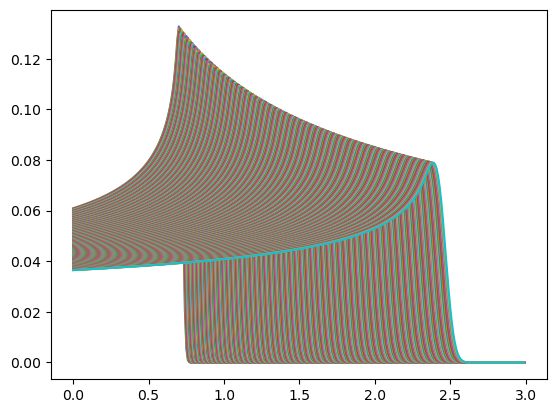

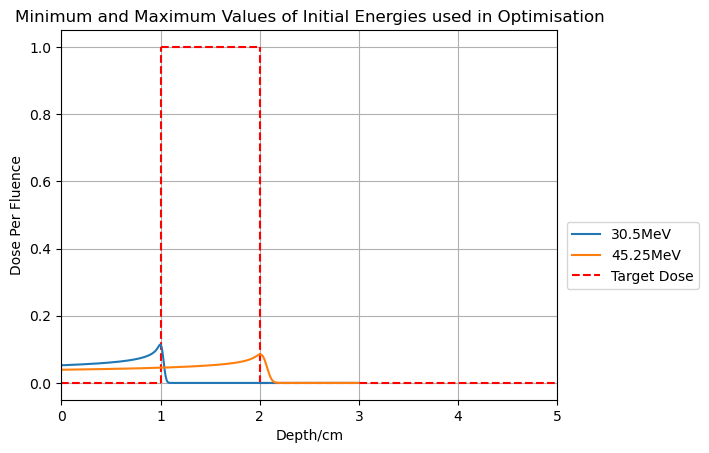

In [6]:
lower = 1;upper=2;dose =1;
energyData2 = FindBestLowerUpperEZeros(lower, upper)
plt.show()

lower = 1; upper = 2; dose = 1

lowerdf = energyData2[(energyData2["rMax"] == lower)]
upperdf = energyData2[(energyData2["rMax"] == upper)]
eZeroLower = lowerdf.eZero.iloc[0]; 
eZeroUpper = upperdf.eZero.iloc[len(upperdf)-1];


x = np.arange(0,3,0.01)

y1 = Functionb(x,eZeroLower)
y2 = Functionb(x,eZeroUpper)
plt.figure()
#PlotCustomBox(1,2,0.12)
plt.plot(x,y1, label = str(round(eZeroLower,3)) + "MeV")
plt.plot(x,y2, label = str(round(eZeroUpper,3)) + "MeV")

plt.title("Minimum and Maximum Values of Initial Energies used in Optimisation")
plt.ylabel("Dose Per Fluence")
plt.xlabel("Depth/cm")

plt.hlines(y=dose,xmin = lower,xmax = upper, color='r', linestyles='dashed', label = "Target Dose")
plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
plt.hlines(y=0,xmin = upper,xmax = 20, color='r', linestyles='dashed')
plt.vlines(x=lower,ymin = 0,ymax = dose, color='r', linestyles='dashed')
plt.vlines(x=upper,ymin = 0,ymax = dose, color='r', linestyles='dashed') #, label = "Target Range"'



plt.grid()
plt.xlim([0,5])
plt.legend(bbox_to_anchor = (1.3,0.5))

# Eye Error Stagnation
#### be aware of the incerments in the different functions - Plugging in any values will result in errors Consult Noel if needed.


2 Curves
eVals = [30.500000000000078, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 2.4074e-35, first-order optimality 2.26e-21
weights = [ 2.5312635  17.36328715]


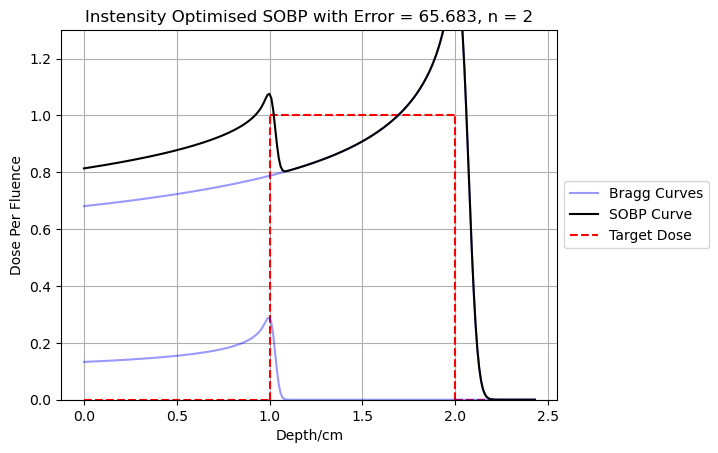

3 Curves
eVals = [30.500000000000078, 37.875000000000185, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 2.2306e-34, first-order optimality 6.79e-20
weights = [ 1.25037205  3.25880626 15.56027519]


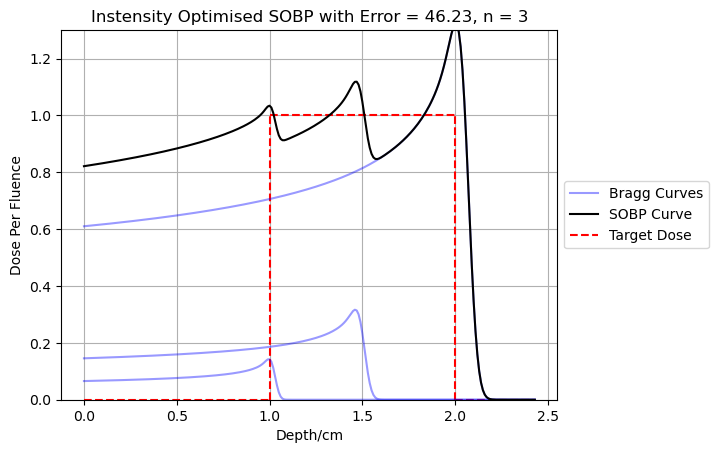

4 Curves
eVals = [30.500000000000078, 35.41666666666681, 40.33333333333355, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 3.1033e-34, first-order optimality 8.23e-20
weights = [ 0.8402597   1.6788681   3.06532405 14.49311943]


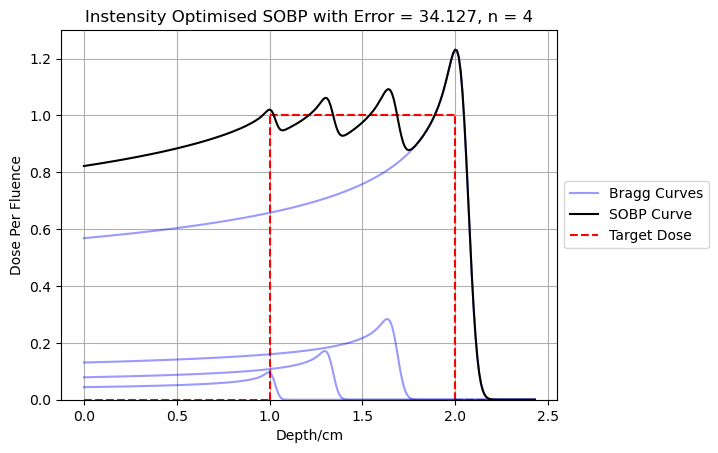

5 Curves
eVals = [30.500000000000078, 34.18750000000013, 37.875000000000185, 41.562500000000234, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 7.9181e-34, first-order optimality 1.73e-19
weights = [ 0.64354514  1.11788216  1.66558007  2.87937166 13.75292708]


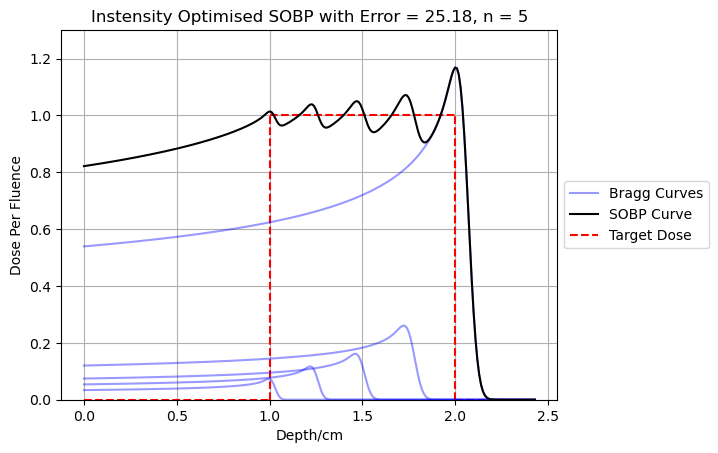

6 Curves
eVals = [30.500000000000078, 33.45000000000012, 36.40000000000016, 39.3500000000002, 42.30000000000024, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 3.9722e-34, first-order optimality 1.02e-19
weights = [ 0.52735633  0.83909057  1.1243775   1.63068188  2.72758064 13.18675172]


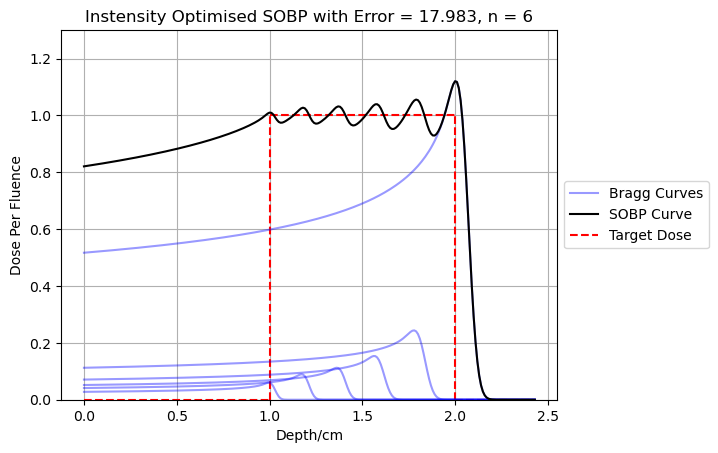

7 Curves
eVals = [30.500000000000078, 32.95833333333344, 35.41666666666681, 37.875000000000185, 40.33333333333355, 42.79166666666691, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 2.9641e-34, first-order optimality 9.28e-20
weights = [ 0.45023329  0.67268063  0.84707714  1.11585366  1.5973127   2.60239793
 12.72661575]


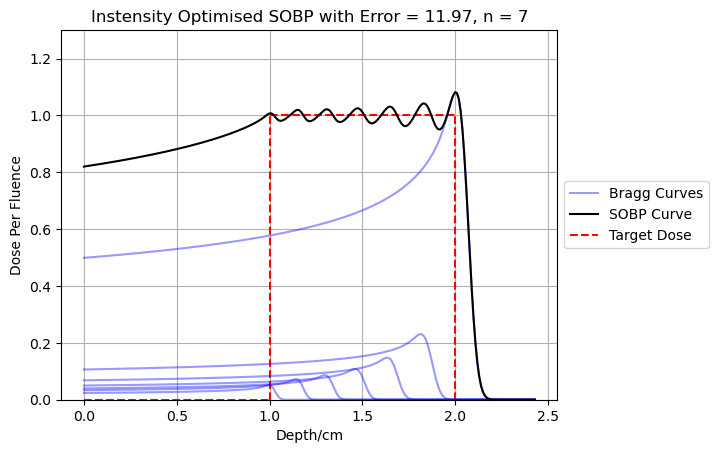

8 Curves
eVals = [30.500000000000078, 32.60714285714297, 34.71428571428585, 36.82142857142874, 38.92857142857162, 41.03571428571451, 43.142857142857395, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 6.5602e-34, first-order optimality 2.07e-19
weights = [ 0.39510604  0.56207244  0.6785948   0.84768541  1.10210221  1.57006573
  2.49668089 12.33742598]


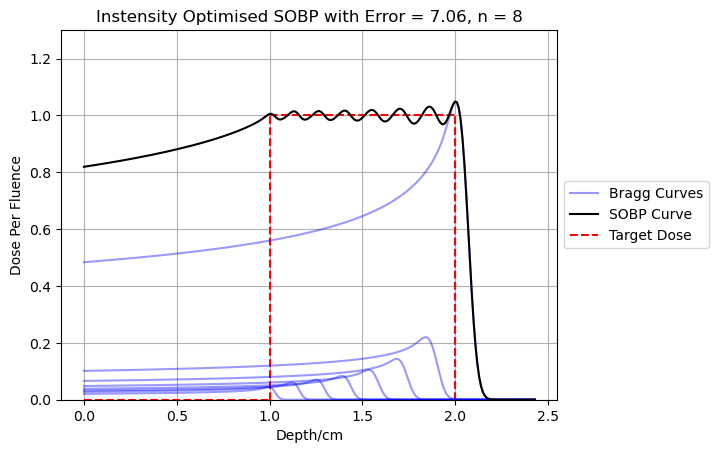

9 Curves
eVals = [30.500000000000078, 32.34375000000011, 34.18750000000013, 36.031250000000156, 37.875000000000185, 39.718750000000206, 41.562500000000234, 43.406250000000256, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 3.3918e-32, first-order optimality 1.69e-18
weights = [ 0.35363649  0.48304283  0.56571004  0.68178897  0.84384409  1.08643841
  1.54771984  2.40772212 11.99925614]


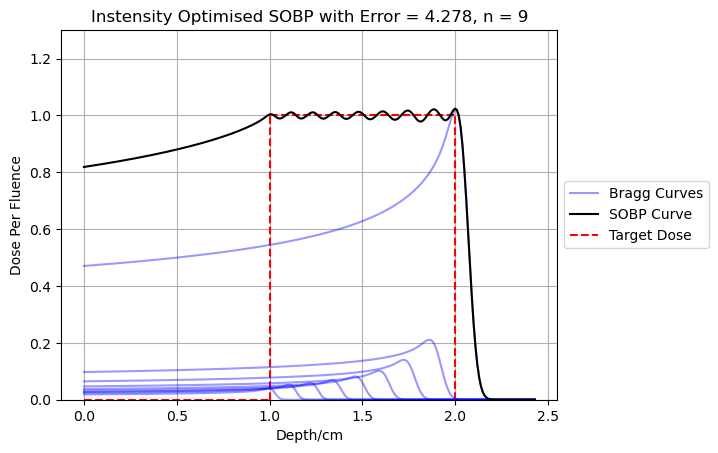

10 Curves
eVals = [30.500000000000078, 32.13888888888899, 33.7777777777779, 35.41666666666681, 37.05555555555573, 38.694444444444635, 40.33333333333355, 41.97222222222246, 43.61111111111137, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 8.5668e-32, first-order optimality 2.82e-18
weights = [ 0.32127584  0.42355821  0.48474749  0.56977134  0.68088059  0.83818805
  1.06992393  1.52738077  2.33279206 11.70240531]


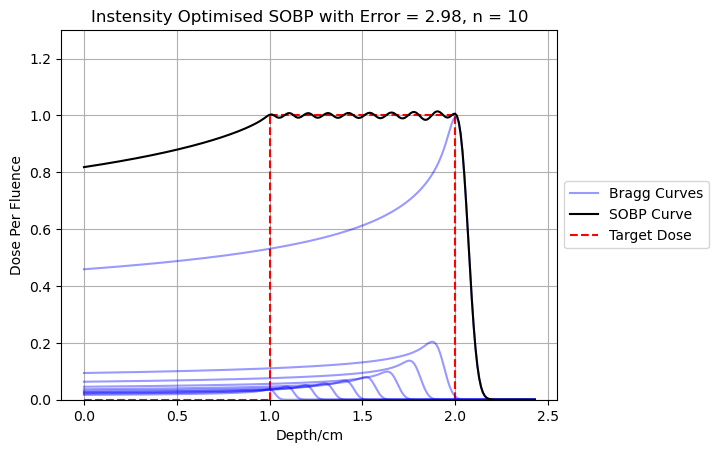

11 Curves
eVals = [30.500000000000078, 31.975000000000097, 33.45000000000012, 34.92500000000014, 36.40000000000016, 37.87500000000018, 39.3500000000002, 40.82500000000022, 42.30000000000024, 43.77500000000026, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 7.0059e-32, first-order optimality 2.68e-18
weights = [ 0.29536662  0.37696717  0.42385736  0.48888478  0.57036503  0.67790586
  0.83162086  1.05306602  1.50737089  2.26540125 11.44455704]


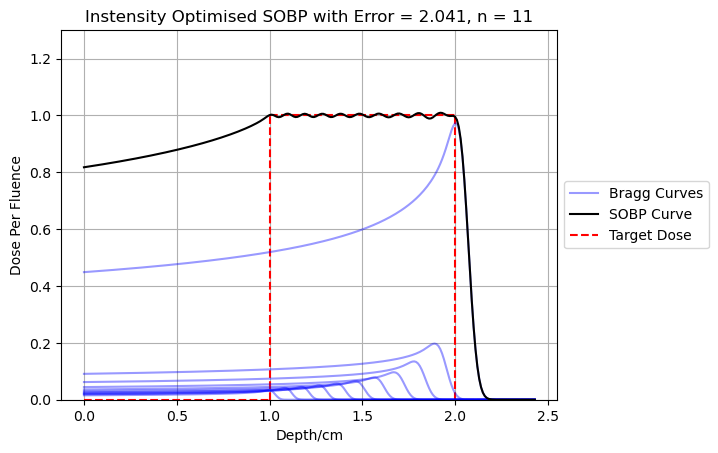

12 Curves
eVals = [30.500000000000078, 31.84090909090919, 33.1818181818183, 34.52272727272741, 35.863636363636516, 37.204545454545624, 38.54545454545474, 39.886363636363846, 41.227272727272954, 42.56818181818206, 43.90909090909118, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 6.8308e-32, first-order optimality 2.77e-18
weights = [ 0.27426757  0.33932024  0.37638998  0.42786081  0.48991721  0.56938404
  0.67347821  0.82464063  1.03597719  1.48775502  2.19666186 11.22696093]


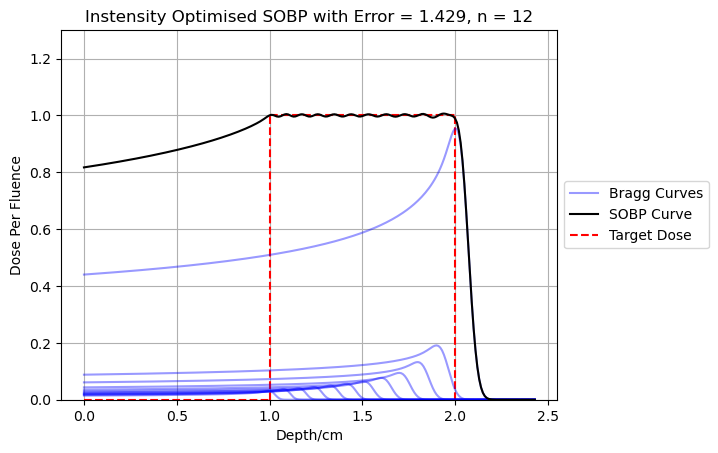

13 Curves
eVals = [30.500000000000078, 31.729166666666764, 32.95833333333344, 34.18750000000013, 35.41666666666681, 36.6458333333335, 37.875000000000185, 39.10416666666686, 40.33333333333355, 41.562500000000234, 42.79166666666691, 44.0208333333336, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 1.0837e-31, first-order optimality 3.63e-18
weights = [ 0.25690646  0.30812238  0.3383949   0.38013037  0.42908569  0.48965537
  0.56727973  0.6680046   0.81756904  1.01844215  1.46958607  2.11829438
 11.05113626]


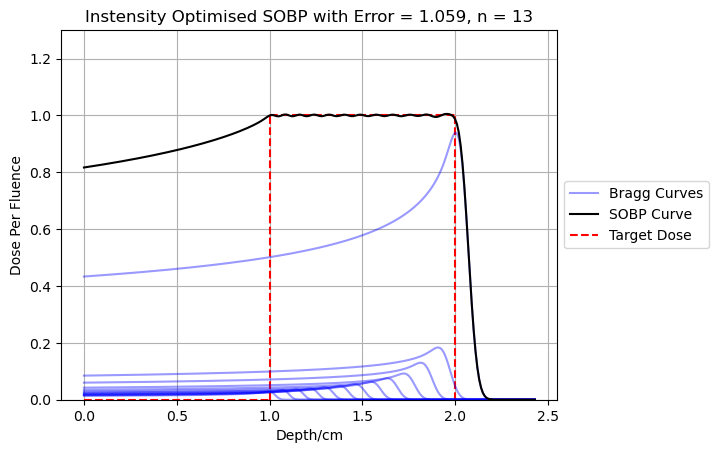

14 Curves
eVals = [30.500000000000078, 31.63461538461548, 32.76923076923088, 33.90384615384628, 35.03846153846168, 36.173076923077076, 37.30769230769248, 38.44230769230788, 39.57692307692328, 40.71153846153868, 41.84615384615408, 42.98076923076948, 44.11538461538488, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 1.2932e-31, first-order optimality 4.12e-18
weights = [ 0.24253711  0.28172558  0.30734505  0.34181428  0.38133549  0.42939307
  0.4882699   0.56452261  0.66165118  0.81071504  1.00005689  1.45416094
  2.02451601 10.91706273]


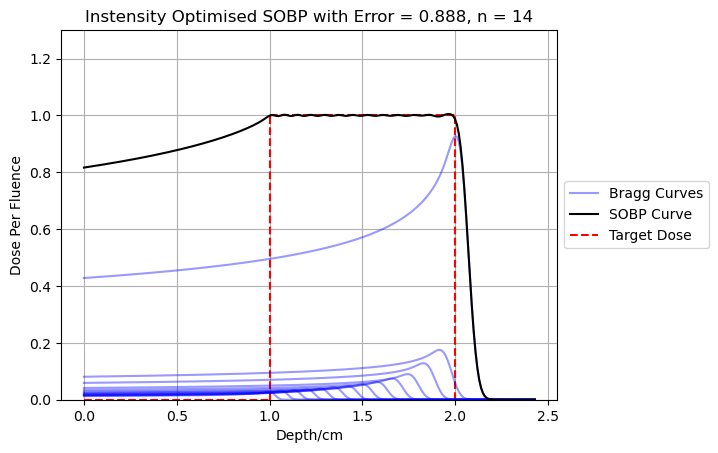

15 Curves
eVals = [30.500000000000078, 31.553571428571523, 32.60714285714297, 33.660714285714405, 34.71428571428585, 35.767857142857295, 36.82142857142874, 37.875000000000185, 38.92857142857162, 39.98214285714307, 41.03571428571451, 42.08928571428596, 43.142857142857395, 44.19642857142884, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 2.1806e-31, first-order optimality 5.60e-18
weights = [ 0.23061221  0.25898759  0.28157869  0.31033325  0.34301556  0.38183272
  0.4288237   0.48608739  0.56140863  0.65448462  0.80437668  0.9804093
  1.44261869  1.9123386  10.82286151]


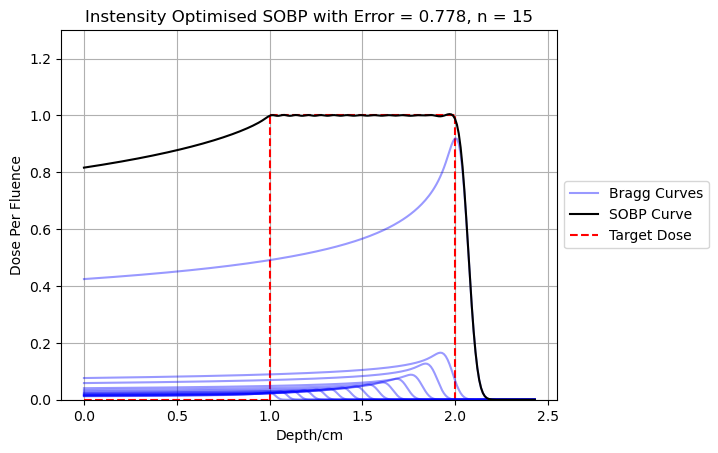

16 Curves
eVals = [30.500000000000078, 31.483333333333427, 32.466666666666775, 33.45000000000012, 34.433333333333465, 35.41666666666681, 36.40000000000016, 37.38333333333351, 38.36666666666685, 39.3500000000002, 40.33333333333355, 41.3166666666669, 42.30000000000024, 43.28333333333359, 44.266666666666936, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 1.7354e-31, first-order optimality 5.14e-18
weights = [ 0.22071107  0.23909349  0.25993094  0.2840109   0.31152567  0.34368572
  0.38151319  0.42773629  0.4832206   0.5582054   0.6465047   0.79881317
  0.95918217  1.43583984  1.78079009 10.7654657 ]


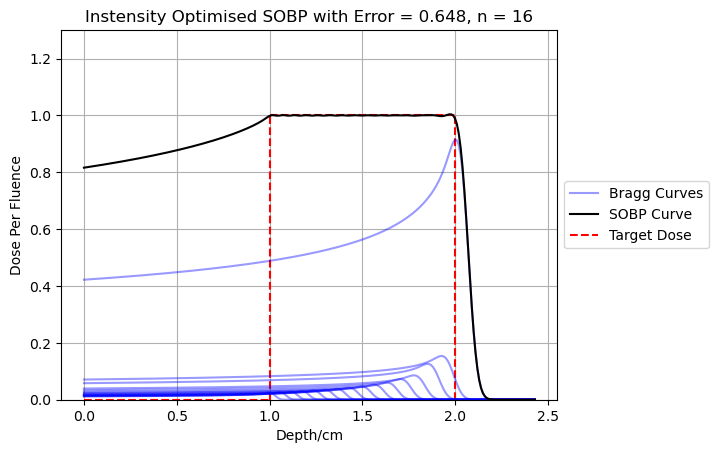

17 Curves
eVals = [30.500000000000078, 31.421875000000092, 32.34375000000011, 33.265625000000114, 34.18750000000013, 35.10937500000014, 36.031250000000156, 36.95312500000017, 37.875000000000185, 38.79687500000019, 39.718750000000206, 40.64062500000022, 41.562500000000234, 42.48437500000024, 43.406250000000256, 44.32812500000027, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 1.9840e-31, first-order optimality 5.65e-18
weights = [ 0.21250414  0.22143493  0.24158736  0.26161068  0.28531428  0.31216441
  0.34375284  0.38061313  0.42631103  0.47974967  0.55512109  0.63770101
  0.79421338  0.93615043  1.43453897  1.62979007 10.74158966]


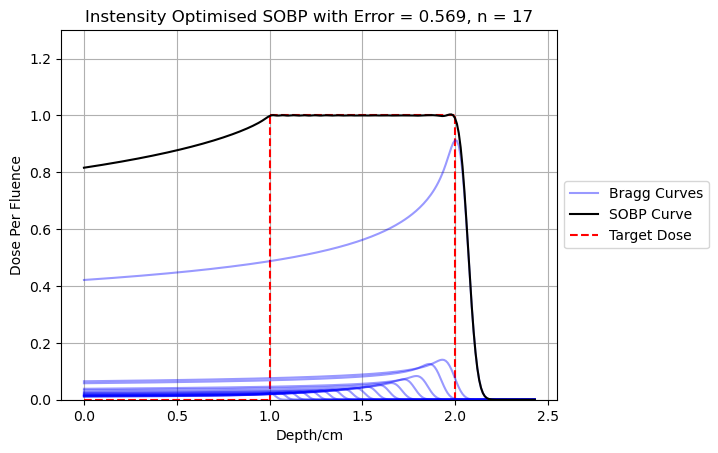

18 Curves
eVals = [30.500000000000078, 31.36764705882362, 32.235294117647165, 33.1029411764707, 33.970588235294244, 34.83823529411779, 35.70588235294133, 36.573529411764866, 37.44117647058841, 38.30882352941195, 39.17647058823549, 40.04411764705904, 40.911764705882575, 41.77941176470612, 42.64705882352966, 43.5147058823532, 44.38235294117674, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 1.8752e-31, first-order optimality 5.63e-18
weights = [ 0.20572637  0.2055544   0.22593289  0.24229487  0.26312046  0.28590501
  0.31234347  0.34338332  0.37922809  0.42471259  0.47570713  0.5523179
  0.62806621  0.79071235  0.91109672  1.43944568  1.45921198 10.74848374]


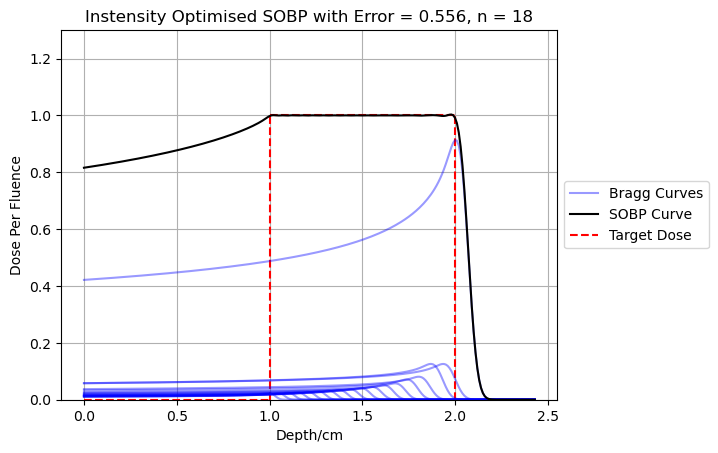

19 Curves
eVals = [30.500000000000078, 31.319444444444535, 32.13888888888899, 32.95833333333344, 33.7777777777779, 34.597222222222356, 35.41666666666681, 36.23611111111127, 37.05555555555573, 37.875000000000185, 38.694444444444635, 39.51388888888909, 40.33333333333355, 41.152777777778006, 41.97222222222246, 42.79166666666691, 43.61111111111137, 44.43055555555583, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 1.6990e-31, first-order optimality 5.52e-18
weights = [ 0.20016807  0.19108734  0.21253012  0.22537575  0.24421699  0.2634667
  0.28637     0.31196185  0.34279265  0.37737084  0.42309678  0.47109245
  0.54992115  0.61758663  0.78843982  0.88370976  1.45148155  1.26834617
 10.78428661]


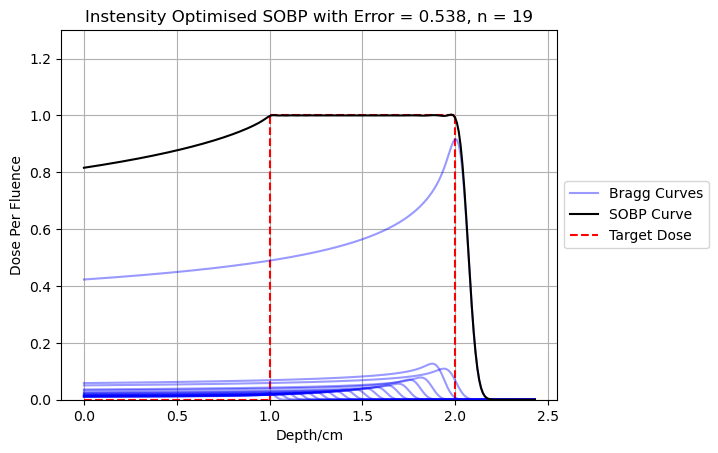

20 Curves
eVals = [30.500000000000078, 31.276315789473774, 32.05263157894747, 32.82894736842116, 33.60526315789486, 34.38157894736855, 35.15789473684225, 35.934210526315944, 36.710526315789636, 37.486842105263335, 38.26315789473703, 39.039473684210726, 39.81578947368442, 40.59210526315812, 41.36842105263181, 42.1447368421055, 42.9210526315792, 43.69736842105289, 44.473684210526585, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 2.5844e-31, first-order optimality 7.03e-18
weights = [ 0.19565752  0.17775228  0.2010232   0.2103962   0.22789555  0.2442529
  0.26408217  0.28622299  0.31134705  0.34196221  0.37512899  0.42154258
  0.46592069  0.54801227  0.60623349  0.78756733  0.8535128   1.47188098
  1.05573406 10.84803241]


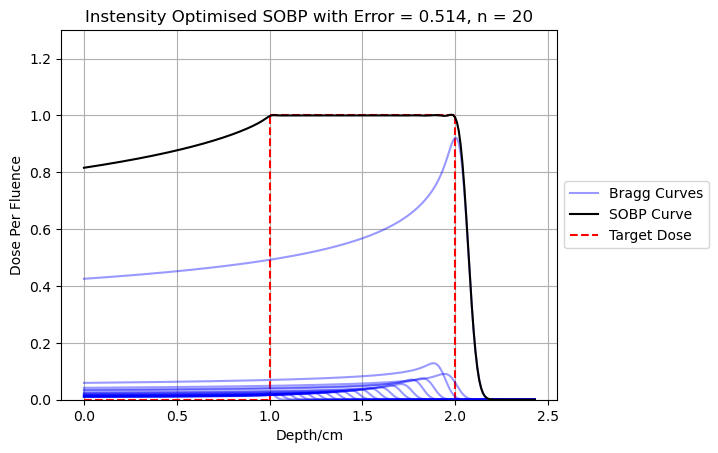

21 Curves
eVals = [30.500000000000078, 31.23750000000009, 31.975000000000097, 32.71250000000011, 33.45000000000012, 34.18750000000013, 34.92500000000014, 35.66250000000015, 36.40000000000016, 37.13750000000017, 37.87500000000018, 38.612500000000196, 39.3500000000002, 40.08750000000021, 40.82500000000022, 41.562500000000234, 42.30000000000024, 43.03750000000025, 43.77500000000026, 44.51250000000027, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 1.8651e-31, first-order optimality 6.08e-18
weights = [ 0.19206237  0.16530755  0.19117203  0.19692145  0.21381591  0.2273716
  0.24524666  0.26374965  0.28616113  0.31023045  0.34114213  0.37242099
  0.42019787  0.46014108  0.54670149  0.59390626  0.78837247  0.81980574
  1.50227128  0.81920326 10.93948935]


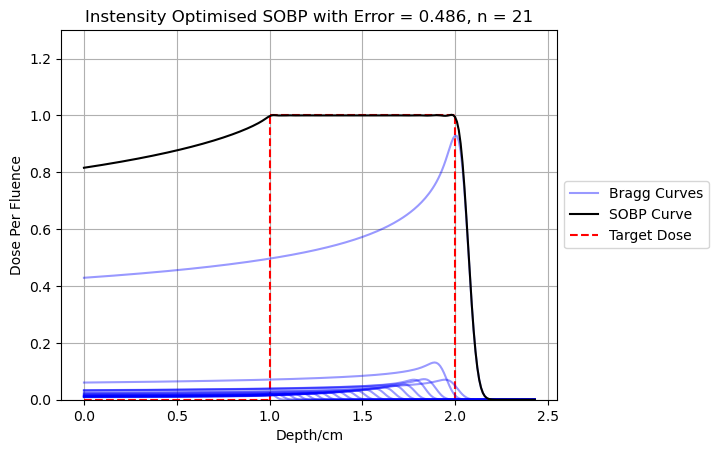

22 Curves
eVals = [30.500000000000078, 31.20238095238104, 31.904761904762, 32.60714285714297, 33.309523809523924, 34.01190476190489, 34.71428571428585, 35.41666666666681, 36.11904761904778, 36.82142857142874, 37.5238095238097, 38.226190476190666, 38.92857142857162, 39.630952380952586, 40.33333333333355, 41.03571428571451, 41.738095238095475, 42.44047619047643, 43.142857142857395, 43.84523809523836, 44.54761904761932, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 2.5204e-31, first-order optimality 7.29e-18
weights = [ 0.18927088  0.15356742  0.18275851  0.18469017  0.20152714  0.21258666
  0.22871771  0.24489045  0.26370844  0.2856345   0.30896371  0.34022789
  0.36934931  0.41907646  0.45376963  0.54605641  0.58047489  0.7912294
  0.78166811  1.54468483  0.55602157 11.0589294 ]


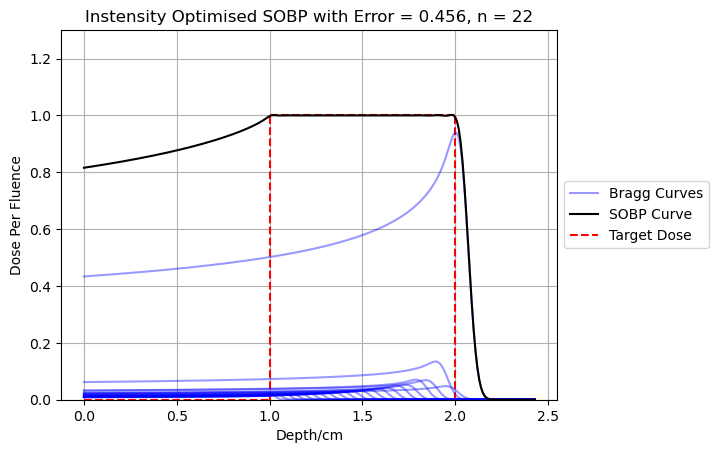

23 Curves
eVals = [30.500000000000078, 31.170454545454632, 31.84090909090919, 32.51136363636374, 33.1818181818183, 33.852272727272855, 34.52272727272741, 35.19318181818196, 35.863636363636516, 36.53409090909107, 37.204545454545624, 37.875000000000185, 38.54545454545474, 39.21590909090929, 39.886363636363846, 40.5568181818184, 41.227272727272954, 41.89772727272751, 42.56818181818206, 43.23863636363662, 43.90909090909118, 44.57954545454573, 45.250000000000284]
The unconstrained solution is optimal.
Final cost 2.1993e-31, first-order optimality 6.94e-18
weights = [ 0.18720255  0.14235416  0.17566182  0.17338795  0.19090112  0.19924984
  0.2145947   0.22793151  0.24539004  0.26281261  0.28536317  0.30717603
  0.33951305  0.36576346  0.41834056  0.44670215  0.54624257  0.56568186
  0.79668638  0.73789334  1.60162384  0.26294651 11.20700155]


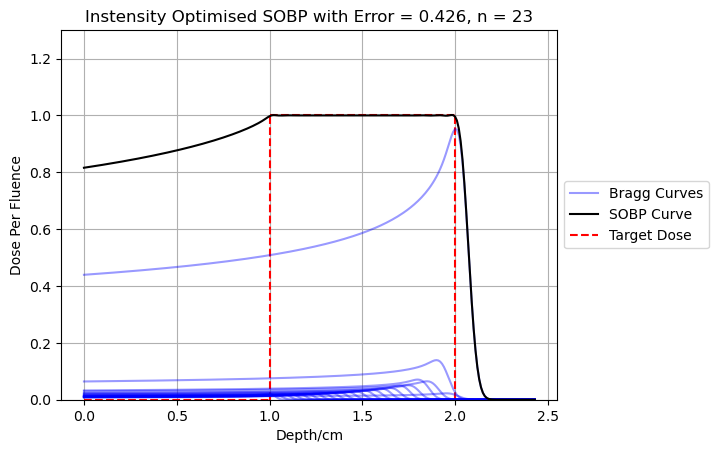

24 Curves
eVals = [30.500000000000078, 31.141304347826175, 31.78260869565227, 32.423913043478365, 33.065217391304465, 33.70652173913056, 34.34782608695665, 34.98913043478275, 35.630434782608845, 36.27173913043494, 36.91304347826104, 37.55434782608713, 38.19565217391323, 38.836956521739324, 39.47826086956542, 40.11956521739152, 40.76086956521761, 41.40217391304371, 42.043478260869804, 42.6847826086959, 43.326086956522, 43.96739130434809, 44.60869565217419, 45.250000000000284]
The first-order optimality measure is less than `tol`.
Number of iterations 4, initial cost 1.4600e-06, final cost 4.8234e-14, first-order optimality 2.90e-12.
weights = [ 0.18585667  0.13160486  0.16979874  0.16298     0.18162714  0.18755886
  0.20185872  0.21403133  0.22794537  0.2463205   0.26007844  0.28880042
  0.29929959  0.34882303  0.34748367  0.43967418  0.4102776   0.58540928
  0.50788755  0.84565184  0.6727852   1.64174301  0.09854081 11.24430071]


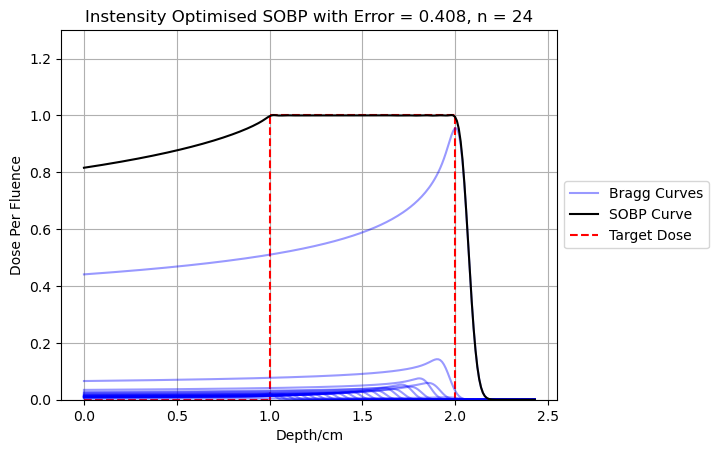

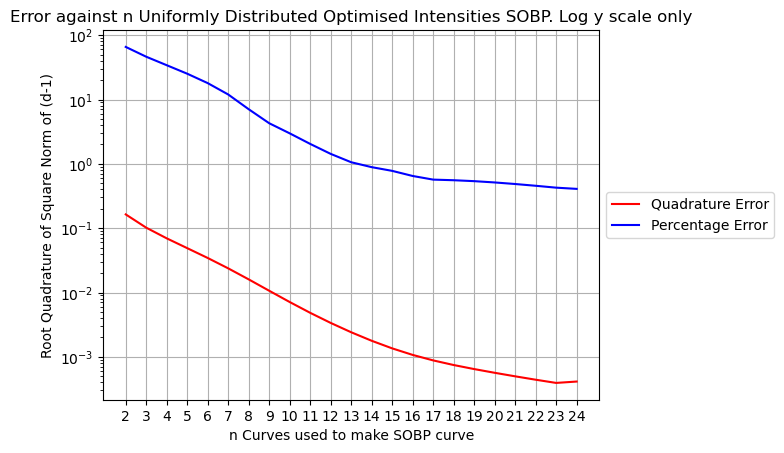

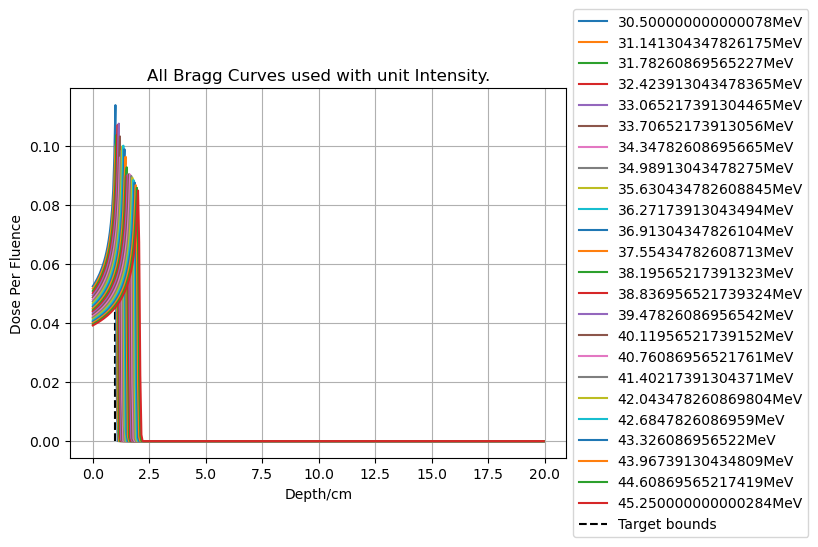

n_least error = 23
23
The unconstrained solution is optimal.
Final cost 1.9305e-31, first-order optimality 6.24e-18
w[ 0.18580726  0.13155508  0.16976713  0.16288499  0.18164541  0.1873429
  0.20205501  0.21346002  0.22870313  0.24474324  0.26242474  0.28458145
  0.30567915  0.33835795  0.36280802  0.416607    0.4415702   0.54355993
  0.55619593  0.79486223  0.70646183  1.64416475 11.33727674]


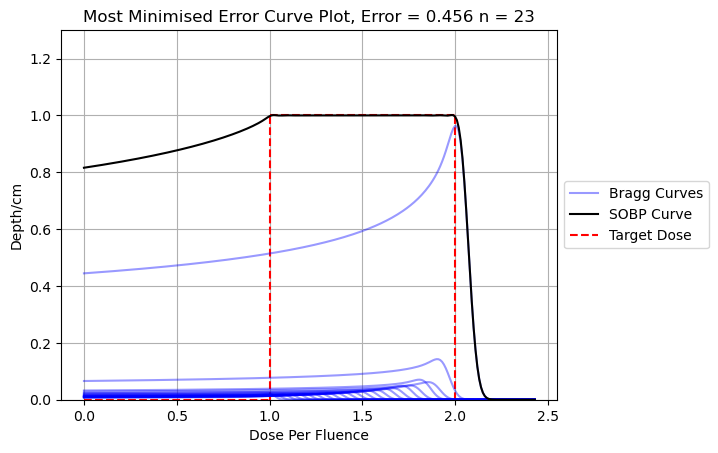

23
The unconstrained solution is optimal.
Final cost 1.9305e-31, first-order optimality 6.24e-18


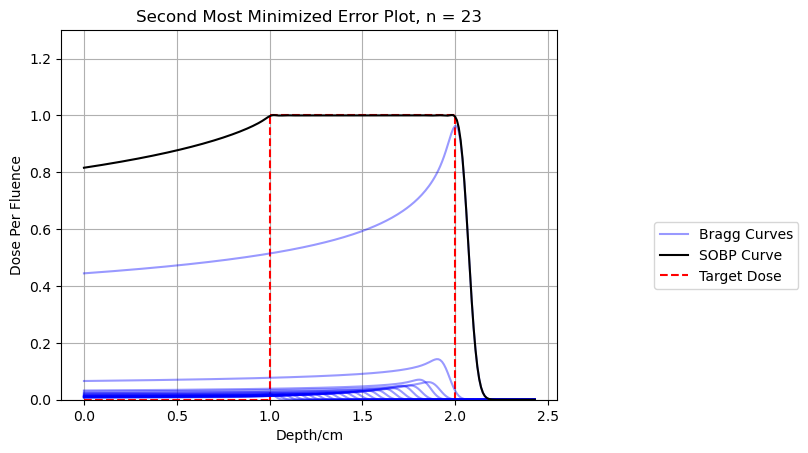

In [7]:
yValues = PlotErrorStagnation(lower,upper,dose,eZeroLower,eZeroUpper)




# Rho Stuff
We need a way to figure out how much enery the cuvre has left 


In [ ]:
def EnergyLeft(x,eZero):
    rZero = alpha*(pow(eZero,p))
    e = (1/(pow(alpha,(1/p)))*pow((rZero- x),(1/p)))
    return(e)

In [ ]:
eList = []
for x in x1:
    e = EnergyLeft(x,120)
    eList.append(e)
    
plt.plot(x1,eList)
eMax = max(eList)
eMax